In [1]:

'''
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing import image
'''


# import the necessary packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
import pickle
import cv2
import numpy as np
import os
from os import listdir
import glob

In [2]:
train_dir ="data/train/"
test_dir="data/test/"

In [3]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [4]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes
43429 Train images
10876 Test images


In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 43429 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


In [7]:

# load the VGG16 network, ensuring the head FC layer sets are
# left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(38, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'average_pooling2d', 'flatten', 'dense', 'dropout', 'dense_1']


In [10]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

INIT_LR = 1e-3
EPOCHS = 10

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# train the network
print("[INFO] training network...")

# distribution
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])



train=model.fit(train_generator,
                epochs=EPOCHS,
                validation_data= test_generator ,
                verbose=1)

[INFO] training network...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1358 steps, validate for 340 steps
Epoch 1/10
1358/1358 [==============================] - 562s 414ms/step - loss: 1.8602 - accuracy: 0.4853 - val_loss: 0.9577 - val_accuracy: 0.7492
Epoch 2/10
1358/1358 [==============================] - 549s 404ms/step - loss: 1.0906 - accuracy: 0.6695 - val_loss: 0.6942 - val_accuracy: 0.8033
Epoch 3/10
1358/1358 [==============================] - 529s 390ms/step - loss: 0.9064 - accuracy: 0.7206 - val_loss: 0.5658 - val_accuracy: 0.8373
Epoch 4/10
1358/1358 [==============================] - 506s 373ms/step - loss: 0.8021 - accuracy: 0.7505 - val_loss: 0.5063 - val_accuracy: 0.8547
Epoch 5/10
1358/1358 [==============================] - 504s 371ms/step - loss: 0.7441 - accuracy: 0.7673 - val_loss: 0.4733 - val_accuracy: 0.8611
Epoch 6/10
1358/1358 [==============================] - 500s 368ms/step - loss: 0.7025 - accuracy: 0.7795 - val_loss: 0.4600 - val_accurac

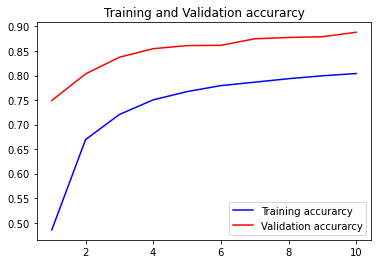

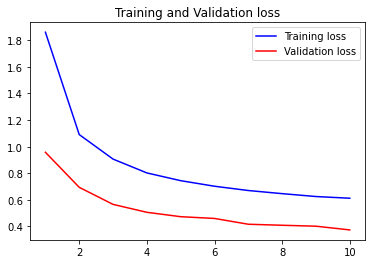

In [21]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [22]:
train=model.fit(train_generator,
                epochs=EPOCHS,
                validation_data= test_generator ,
                verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1358 steps, validate for 340 steps
Epoch 1/10
1358/1358 [==============================] - 534s 393ms/step - loss: 0.5972 - accuracy: 0.8085 - val_loss: 0.3726 - val_accuracy: 0.8849
Epoch 2/10
1358/1358 [==============================] - 504s 371ms/step - loss: 0.5867 - accuracy: 0.8125 - val_loss: 0.3638 - val_accuracy: 0.8911
Epoch 3/10
1358/1358 [==============================] - 509s 374ms/step - loss: 0.5777 - accuracy: 0.8151 - val_loss: 0.3571 - val_accuracy: 0.8917
Epoch 4/10
1358/1358 [==============================] - 554s 408ms/step - loss: 0.5610 - accuracy: 0.8190 - val_loss: 0.3507 - val_accuracy: 0.8958
Epoch 5/10
1358/1358 [==============================] - 504s 371ms/step - loss: 0.5627 - accuracy: 0.8212 - val_loss: 0.3401 - val_accuracy: 0.8975
Epoch 6/10
1358/1358 [==============================] - 504s 371ms/step - loss: 0.5475 - accuracy: 0.8254 - val_loss: 0.3339 - val_accuracy: 0.8994
Epoch 7/10
1358/1

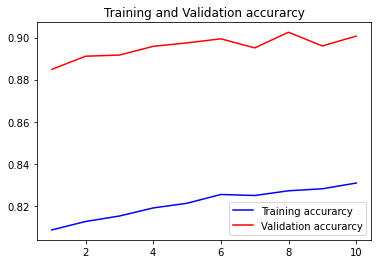

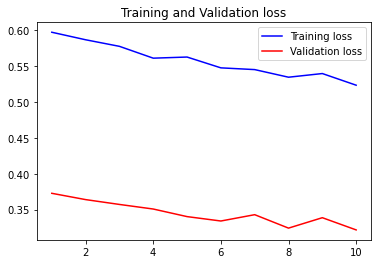

In [24]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [23]:
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 43429 images belonging to 38 classes.


In [25]:
train=model.fit(train_generator,
                epochs=3,
                validation_data= test_generator ,
                verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1358 steps, validate for 340 steps
Epoch 1/3
1358/1358 [==============================] - 529s 390ms/step - loss: 0.5247 - accuracy: 0.8310 - val_loss: 0.3147 - val_accuracy: 0.9043
Epoch 2/3
1358/1358 [==============================] - 508s 374ms/step - loss: 0.5186 - accuracy: 0.8317 - val_loss: 0.3115 - val_accuracy: 0.9053
Epoch 3/3
1358/1358 [==============================] - 507s 374ms/step - loss: 0.5129 - accuracy: 0.8359 - val_loss: 0.3233 - val_accuracy: 0.8974
